<a href="https://colab.research.google.com/github/aashish010h/face-aging-backend-fastapi/blob/main/face_aging_system_backend_fastapi_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T074235Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da63c184ba45e49191337d23a431bd04faf92a75a96ce32ac7b8dba7a9db107a8d3c7048a8eee5d241873f44b54cbde3dcac6215cfe94e3cf4dee17f96d8f2f5d9072a959eb7c12a47babc6a6660e11f122067393bd1fee68bc3fac29c890dbbbb9aa909d618fa2e9486f1505a3afda6c87770d004592e6fabca94eb1d67112809cbc38074025ae138ddcf63c1e0652836a5adc0dd6273c211065775dcab5eb3b944ea45e4cf096d12e096a57825750e943668a5ddc5b4541e77cd3b63b80891fdf5d72997b81b6b0a97f7381b19ac3f822f377a985ee95eaec053db04cc41f3ce2fb39defa99fce62062876fa3e55b9bde6169aaa54e3297ceb27aae35dc010a'


img_input_path='/projectAge/input'
img_woking_path='/projectAge/working'


!umount /projectAge/input/ 2> /dev/null
shutil.rmtree('/projectAge/input', ignore_errors=True)
os.makedirs(img_input_path, 0o777, exist_ok=True)
os.makedirs(img_woking_path, 0o777, exist_ok=True)

try:
  os.symlink(img_input_path, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(img_woking_path, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(img_input_path, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)






In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/projectAge/input/utkface-new/UTKFace"
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split("_")
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df["image"], df["age"], df["gender"] = image_paths, age_labels, gender_labels
df.head(5)

,image,age,gender
0,/projectAge/input/utkface-new/UTKFace/46_0_0_2...,46,0
1,/projectAge/input/utkface-new/UTKFace/30_1_3_2...,30,1
2,/projectAge/input/utkface-new/UTKFace/28_1_1_2...,28,1
3,/projectAge/input/utkface-new/UTKFace/10_0_0_2...,10,0
4,/projectAge/input/utkface-new/UTKFace/36_1_3_2...,36,1


In [ ]:
gender_dict = {0:"Male",1:"Female"}

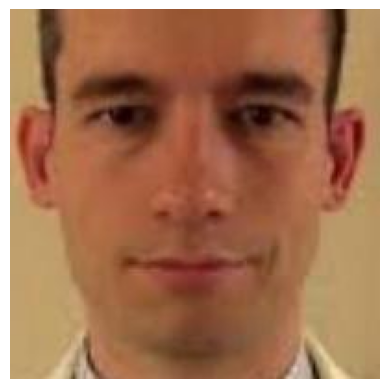

In [ ]:
from PIL import Image
img = Image.open(df["image"][0])
plt.axis("off")
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

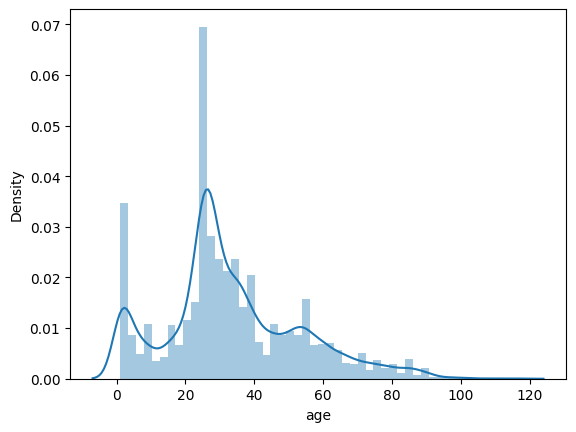

In [ ]:
sns.distplot(df["age"])

In [ ]:
# plt.figure(figsize=(25,25))
# files = df.iloc[0:25]

# for index, file, age, gender in files.itertuples():
#     # plt.subplot(5,5, index+1)
#     # img = load_img(file)
#     # img = np.array(img)
#     # plt.imshow(img)
#     # plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
#     # plt.axis("off")

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df["image"])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0

In [ ]:
y_gender = np.array(df["gender"])
y_age = np.array(df["age"])

In [ ]:
input_shape = (128,128,1)

In [ ]:
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name="gender_out")(dropout_1)
output_2 = Dense(1, activation='relu', name="age_out")(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=["binary_crossentropy", "mae"], optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 15s 14ms/step - loss: 13.5747 - gender_out_loss: 0.5498 - age_out_loss: 13.0249 - gender_out_accuracy: 0.7144 - age_out_accuracy: 0.0414 - val_loss: 10.7761 - val_gender_out_loss: 0.3968 - val_age_out_loss: 10.3793 - val_gender_out_accuracy: 0.8153 - val_age_out_accuracy: 0.0272
Epoch 2/30
593/593 [==============================] - 7s 12ms/step - loss: 9.9851 - gender_out_loss: 0.3622 - age_out_loss: 9.6230 - gender_out_accuracy: 0.8364 - age_out_accuracy: 0.0228 - val_loss: 8.6253 - val_gender_out_loss: 0.3033 - val_age_out_loss: 8.3220 - val_gender_out_accuracy: 0.8610 - val_age_out_accuracy: 0.0082
Epoch 3/30
593/593 [==============================] - 7s 11ms/step - loss: 8.8670 - gender_out_loss: 0.3011 - age_out_loss: 8.5659 - gender_out_accuracy: 0.8657 - age_out_accuracy: 0.0144 - val_loss: 7.7923 - val_gender_out_loss: 0.2751 - val_age_out_loss: 7.5172 - val_gender_out_accuracy: 0.8792 - val_age_out_accuracy: 0.0078
Epoch 4/

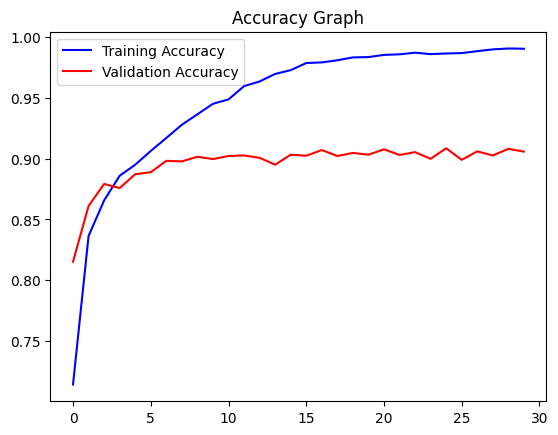

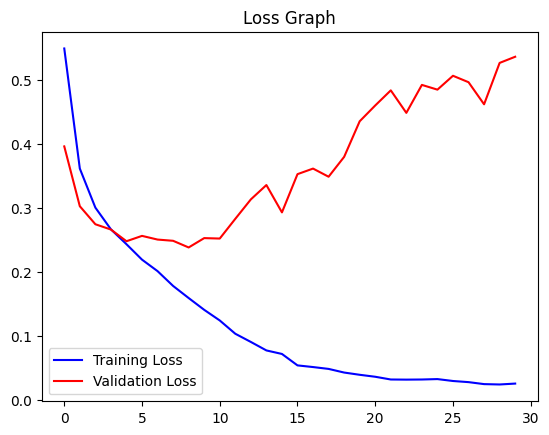

In [ ]:
acc = history.history["gender_out_accuracy"]
val_acc = history.history["val_gender_out_accuracy"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.figure()

loss = history.history["gender_out_loss"]
val_loss = history.history["val_gender_out_loss"]

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

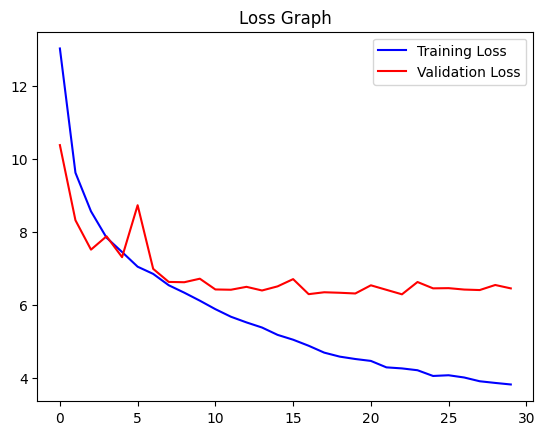

In [ ]:
loss = history.history["age_out_loss"]
val_loss = history.history["val_age_out_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

Original Gender: Male, Original Age: 24
1/1 [==============================] - 0s 185ms/step
Predicted Gender: Male, Predicted Age: 24


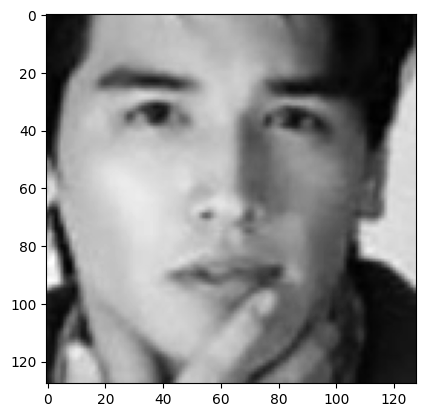

In [ ]:
image_index = 43
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender: Female, Original Age: 22
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female, Predicted Age: 27


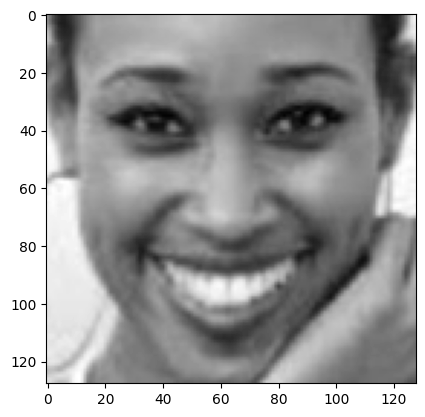

In [ ]:
image_index = 601
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender: Female, Original Age: 25
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female, Predicted Age: 22


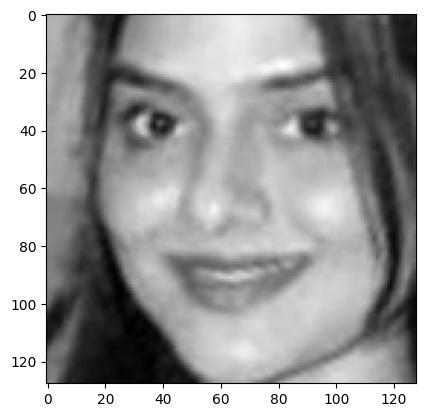

In [ ]:
image_index = 1402
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

In [ ]:
model.save("model.h5")

In [ ]:
!pip install colabcode
!pip install fastapi
!pip install python-multipart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of nbclassic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.

In [ ]:
!ngrok authtoken 2ctN4K4w9KQeSb0aZ50r1A6kbdu_4fPkEAV4sjEt1wDxa1PUX
from colabcode import ColabCode
cc = ColabCode(port=12000, code=False)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
import io
import numpy as np
from tensorflow.keras.models import load_model

app = FastAPI()

gender_dict = {0: "Male", 1: "Female"}

model = load_model("model.h5")

def preprocess_image(contents):
    img = Image.open(io.BytesIO(contents)).convert("L").resize((128, 128))
    img_array = np.array(img).reshape((1, 128, 128, 1)) / 255.0
    return img_array

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    img_array = preprocess_image(contents)
    pred_gender, pred_age = model.predict(img_array)
    pred_gender = gender_dict[round(pred_gender[0][0])]
    pred_age = round(pred_age[0][0])

    return JSONResponse({"gender": pred_gender, "age": int(pred_age)})

# Define allowed origins for CORS
origins = [
    "http://localhost",
    "http://localhost:8080",
    "http://localhost:5173",
    # Add more origins as needed
]

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["POST"],
    allow_headers=["*"],
)



In [ ]:
cc.run_app(app=app)

INFO:     Started server process [1400]
INFO:uvicorn.error:Started server process [1400]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "https://a346-35-204-203-243.ngrok-free.app" -> "http://localhost:12000"
INFO:     49.126.167.39:0 - "POST /predict HTTP/1.1" 307 Temporary Redirect
1/1 [==============================] - 0s 95ms/step
INFO:     49.126.167.39:0 - "POST /predict/ HTTP/1.1" 200 OK
INFO:     49.126.167.39:0 - "POST /predict HTTP/1.1" 307 Temporary Redirect
1/1 [==============================] - 0s 19ms/step
INFO:     49.126.167.39:0 - "POST /predict/ HTTP/1.1" 200 OK
INFO:     49.126.167.39:0 - "POST /predict HTTP/1.1" 307 Temporary Redirect
1/1 [==============================] - 0s 21ms/step
INFO:     49.126.167.39:0 - "POST /predict/ HTTP/1.1" 200 OK
INFO:     49.126.167.39:0 - "POST /predict HTTP/1.1" 307 Temporary Redirect
1/1 [==============================] - 0s 20ms/step
INFO:     49.126.167.39:0 - "POST /predict/ HTTP/1.1" 200 OK
INFO:     49.126.167.39:0 - "POST /predict HTTP/1.1" 307 Temporary Redirect
1/1 [==============================] - 0s 19ms/step
INFO:     49.126.1